In [1]:
options(repr.plot.width=9, repr.plot.height=7)

# The Paired $t$-test

As we have now seen, correlation causes problems in terms of both the properties of the least-squares estimates, as well as the accuracy of the standard errors. We will put the least-squares issues to one side, for the moment, and start by focussing on the standard errors. To do so, we will explore how the humble $t$-test can be adapted to accommodate repeated measurements. In particular, we will see what this tells us about representing repeated measurements within the framework of linear models.


## Paired vs Two-sample $t$-tests

To begin, let us examine the difference in results between a *two-sample* $t$-test and a *paired* $t$-test. To do this, we first simulate correlated data as we did before:

In [2]:
library(MASS)
set.seed(666)

var1  <- 1
var2  <- 1
rho   <- 0.8
covar <- rho*sqrt(var1)*sqrt(var2)

Sigma <- matrix(data=c(var1,covar,covar,var2), nrow=2, ncol=2)
y     <- mvrnorm(n=50, mu=c(1,1.25), Sigma=Sigma)

We can then run a *two-sample* $t$-test using

In [3]:
t.test(x=y[,1], y=y[,2], paired=FALSE, var.equal=TRUE)


	Two Sample t-test

data:  y[, 1] and y[, 2]
t = -0.92759, df = 98, p-value = 0.3559
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6487683  0.2354578
sample estimates:
mean of x mean of y 
0.9601951 1.1668504 


and compare the output to a *paired* $t$-test on the same data

In [4]:
t.test(x=y[,1], y=y[,2], paired=TRUE,  var.equal=TRUE)


	Paired t-test

data:  y[, 1] and y[, 2]
t = -2.4952, df = 49, p-value = 0.01601
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -0.3730884 -0.0402221
sample estimates:
mean difference 
     -0.2066553 


Perhaps the first thing you will notice is that the two-sample $t$-test is *non-significant*, whereas the paired $t$-test is *significant*. However, there is a lot more important information to unpack here. 

Firstly, the output from the *two-sample* test reports the estimated group means as $\hat{\mu}_{1} = 0.96$ and $\hat{\mu}_{2} = 1.17$, meaning that the estimated mean difference is $\hat{\mu}_{1} - \hat{\mu}_{2} = 0.96 - 1.17 = -0.21$. This is the same as reported by the *paired* test. As such, the difference between these methods is not related to the estimated mean difference, as this is *identical*.

Where the two tests differ can be seen in terms of the $t$-statistic itself, the degrees of freedom and the confidence interval. The structure of the $t$-statistic is

$$
t = \frac{\mu_{1} - \mu_{2}}{\text{SE}\{\mu_{1} - \mu_{2}\}},
$$

meaning that we think of the $t$ as the ratio between the mean difference and the standard error of the difference. Given that the mean difference is the same across both methods, the numerator of the test statistic will be identical under both the *two-sample* and *paired* tests. As such, the difference in the $t$ values *must* be coming from a difference in the denominator. In other words, the standard error of the difference changes between the two-sample and paired cases.

This should not be a surprise, given our earlier discussion. If the correlation is *positive*, then we expect the standard error of the difference to be *smaller* when the data are correlated. Indeed, this is what we see here. In both cases, we can recover the standard error by dividing the mean difference by the $t$-statistic. This gives

In [5]:
round(c(-0.207/-0.928, -0.207/-2.495), digits=3)

[1] 0.223 0.083

So, in the *two-sample* case the standard error is $0.223$, which is larger than the standard error in the *paired* case, which is $0.083$. 

### Checking the Standard Error Using Simulation
Given what we know, the conclusion would be that the estimate in the *two-sample* case is *too large*, given the correlation in the data. We can appeal to theory to confirm this, but we can also see that this true using simulation. In the code below, we run 5,000 simulations. In each case, we draw 50 pairs from the theoretical multivariate normal distribution with the given covariance matrix. We calculate the mean difference and then save it. After all 5,000 repetitions, we can plot the simulated sampling distribution of the mean difference and estimate the standard error.


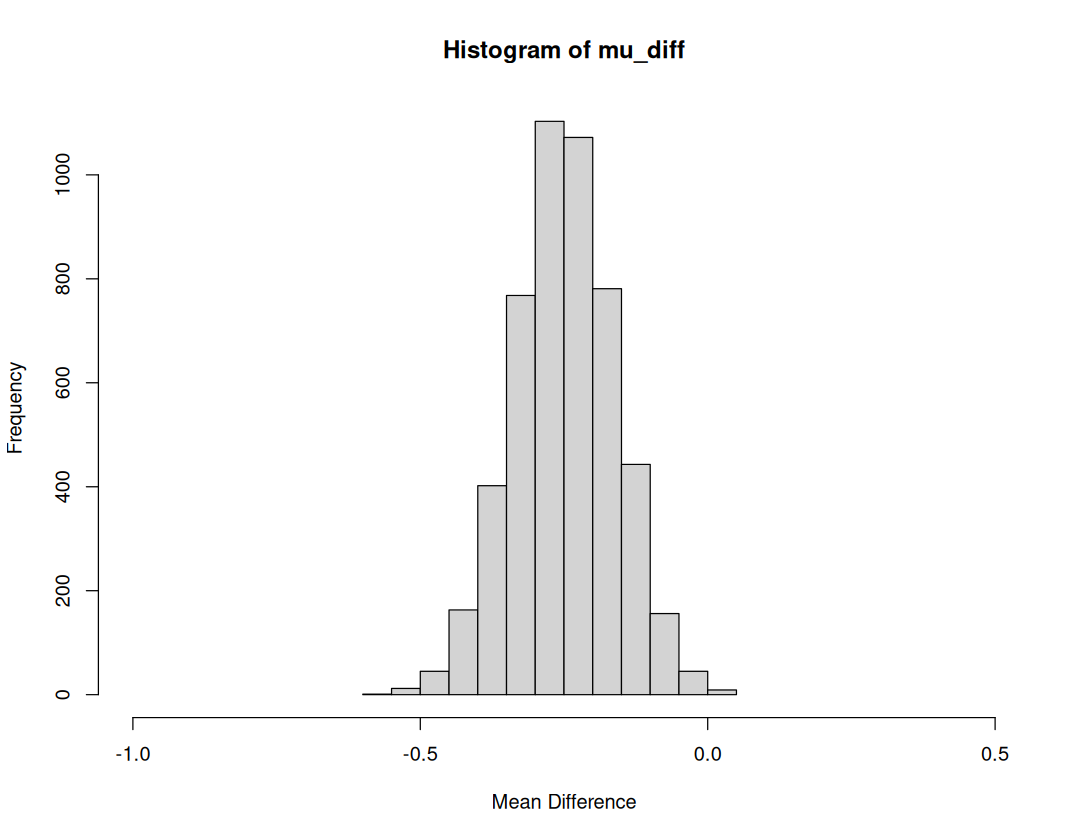

In [6]:
set.seed(666)

var1  <- 1
var2  <- 1
rho   <- 0.8
covar <- rho*sqrt(var1)*sqrt(var2)
Sigma <- matrix(data=c(var1,covar,covar,var2), nrow=2, ncol=2)

mu_diff   <- rep(0,5000)
for (i in 1:5000){
    y.sim      <- mvrnorm(n=50, mu=c(1,1.25), Sigma=Sigma)
    mu_diff[i] <- mean(y.sim[,1]) - mean(y.sim[,2])
}

hist(mu_diff, xlim=c(-1,0.5), xlab='Mean Difference')

The standard error from the simulations is then given by

In [7]:
sd(mu_diff)

[1] 0.08750433

This is very close to estimated standard error of 0.083 from the *paired* test, and is not anywhere near the estimated standard error of 0.223 from the *two-sample* test. As such, we can see that the *paired* test is able to accurately estimate the correct standard error under cases of correlation. 

This should not be surprising, however, the key question for us is *how* the *paired* $t$-test is able to do this.

## The Paired $t$-test as a Linear Model

To begin understanding how this works, it is useful to reframe the $t$-test in terms of a linear model. 

### Two-sample $t$-test as an LM
To see this, we first start with the familiar case of the *two-sample* model. We can fit this as an LM within `R` as follows

In [8]:
library(matrixcalc)

y.long <- vec(t(y))          # Turn y into a column
cond   <- rep(c("A","B"),50) # Create a predictor for the two conditions

two.sample.mod <- lm(y.long ~ cond)
summary(two.sample.mod)


Call:
lm(formula = y.long ~ cond)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.52090 -0.85738  0.01796  0.70661  2.41932 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.9602     0.1575   6.095 2.16e-08 ***
condB         0.2067     0.2228   0.928    0.356    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.114 on 98 degrees of freedom
Multiple R-squared:  0.008703,	Adjusted R-squared:  -0.001412 
F-statistic: 0.8604 on 1 and 98 DF,  p-value: 0.3559


Focussing on the coefficient and tests associated with `CondB` in the table, we can see $t = 0.928$ and $p = 0.356$, which is the same[^foot1] as we saw for the two-sample test earlier. We can also see that the degrees of freedom agree at $98$. So we have managed to successfully implement the *two-sample* $t$-test as a linear model.

Now, we know that this is *incorrect* for correlated data. However, specifying the model in this form allows us to dig deeper into *why* this is wrong, which will then provide us with the insight needed to correct this and thus tell us how the *paired* method is able to accommodate correlation. This will also provide us with the grounding needed to understand the traditional repeated measured ANOVA, as well as mixed-effect model a little later in the unit.

### Variance Sources

### Recreating the Paired $t$-test in the Linear Model

In [9]:
subject <- matrix(data=c(seq(1,50),seq(1,50)), nrow=50, ncol=2)
subject <- vec(t(subject))
subject <- as.factor(subject)

paired.mod <- lm(y.long ~ cond + subject)
summary(paired.mod)


Call:
lm(formula = y.long ~ cond + subject)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9091 -0.1826  0.0000  0.1826  0.9091 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.736326   0.295727   5.871 3.69e-07 ***
condB        0.206655   0.082820   2.495 0.016005 *  
subject2     1.196331   0.414100   2.889 0.005741 ** 
subject3    -1.051564   0.414100  -2.539 0.014328 *  
subject4     1.209435   0.414100   2.921 0.005268 ** 
subject5    -2.817765   0.414100  -6.805 1.33e-08 ***
subject6     0.004824   0.414100   0.012 0.990752    
subject7    -1.953810   0.414100  -4.718 2.02e-05 ***
subject8    -1.475991   0.414100  -3.564 0.000825 ***
subject9    -2.414923   0.414100  -5.832 4.25e-07 ***
subject10   -0.754529   0.414100  -1.822 0.074547 .  
subject11    1.325056   0.414100   3.200 0.002413 ** 
subject12   -2.394042   0.414100  -5.781 5.08e-07 ***
subject13    0.105629   0.414100   0.255 0.799729    
subject14   -2.346537   0.414100  -5

Now, the output here is a bit of mess due to all the subject effects. However, if you look at the coefficient and test for `CondB`, notice that $t = 2.495$ and $p = 0.016$, which is the same as the *paired* $t$-test from earlier. Furthermore, the degrees of freedom are now correct at $49$. As such, adding the subject effects to the model has allowed the *between-subjects* error to be partitioned out and thus the remaining variance calculated from the residuals is *only* the *within-subject* error. This is the error needed to correctly estimate the standard error of the paired difference and thus the model results are now correct.

```{admonition} Advanced: Understanding the coefficients in the paired model
:class: warning, dropdown
So from this, we can see that

$$
\begin{align}
\mu_{1} &= \beta_{0} + \frac{1}{n}\sum_{k=2}^{n+1}\beta_{k} \\
\mu_{2} &= \beta_{0} + \beta_{1} + \frac{1}{n}\sum_{k=2}^{n+1}\beta_{k}.
\end{align}
$$

Solving for both $\beta_{0}$ and $\beta_{1}$ gives

$$
\begin{align}
\beta_{0} &= \mu_{1} - \frac{1}{n}\sum_{k=2}^{n+1}\beta_{k} \\
\beta_{1} &= \beta_{0} + \frac{1}{n}\sum_{k=2}^{n+1}\beta_{k} - \mu_{2} = \mu_{1} - \mu_{2}.
\end{align}
$$

So, rather unituitively, the intercept is actually the mean of the first group, minus the average of the subject effects. This then raises the question of what exactly the subject effects are? We can use a similar approach as above to solve for these. For instance, the expected value of the response from subject 2 in condition A is

$$
\mu_{12} = \beta_{0} + \beta_{2}.
$$

Meaning that the effect for subject 2 is

$$
\beta_{2} = \mu_{12} - \beta_{0}.
$$

As such, the subject effects are effectively *residuals* around the intercept. Importantly, these are *constant offsets*, irrespective of the condition. For instance. As such, subject 2 is expect to lie the same distance from the mean of condition A and the mean of condition B.
```

[^foot1]: Due to the way the factors are coded in `R`, the coefficient is actually the opposite comparison here, hence why the $t$-statistic is *positive* rather than *negative*.